In [2]:
%load_ext autoreload
%autoreload 2

# WIP: Decoding

In [3]:
import numpy as np

npz_fname = 'data/look/epoch-20231214-filtered-trainval.npz'
# npz_fname = 'data/look/epoch20240221_expanded10x_trainval.npz'

ds = np.load(npz_fname, encoding='latin1', allow_pickle=True)
# print(f"num drawings in dataset: {ds.shape[0]}")

train = ds['train']
valid = ds['valid']

len(train), max([len(train[i]) for i in range(len(train))])

(1800, 300)

In [4]:
import torch
from singleline_models.sketch_transformer.trainer import get_default_config, Trainer

run_id = '0135253'

t2 = Trainer.load(run_dir=f'models/{run_id}', run_id=run_id, device='cpu', use_wandb=False)

t2.model

RUN_ID: 0705098

HYPERPARAMETERS:

{
  "n_layer": 4,
  "n_head": 8,
  "d_model": 128,
  "d_ff": 512,
  "d_lowerdim": 256,
  "vocab_size": null,
  "block_size": null,
  "dropout_rate": 0.1,
  "max_seq_length": 250,
  "batch_size": 100,
  "blind_decoder_mask": true,
  "dataset_source": "look",
  "dataset_name": "look_i16__minn10_epsilon1",
  "dataset_fname": "data/look/epoch-20231214-filtered-trainval.npz",
  "augment_stroke_prob": 0.1,
  "use_random_scale": true,
  "random_scale_factor": 0.15,
  "epochs": 50000,
  "lr": 0.001,
  "use_lr_decay": true,
  "min_lr": 1e-05,
  "lr_decay": 0.9999,
  "learning_rate": 0.001
}


truncating 16 - length: 266
truncating 27 - length: 254
truncating 51 - length: 257
truncating 60 - length: 289
truncating 88 - length: 260
truncating 113 - length: 259
truncating 135 - length: 276
truncating 142 - length: 252
truncating 150 - length: 282
truncating 152 - length: 270
truncating 174 - length: 298
truncating 187 - length: 289
truncating 237 - length: 294
tr

Model(
  (encoder): Encoder(
    (embedding): Linear(in_features=5, out_features=128, bias=True)
    (pos_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (enc_layers): ModuleList(
      (0-3): 4 x EncoderLayer(
        (mha): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (ffn): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
        (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (bottleneck_layer): SelfAttn(
    (embedding_layer): Linear(in_features=128, out_features=256, bias=True)
  )
  (expand_layer): DenseExpander(
    (project_layer): Linear(in_features=256, out_features=128, 

In [5]:
hp = t2.hp

hp.__dict__

{'n_layer': 4,
 'n_head': 8,
 'd_model': 128,
 'd_ff': 512,
 'd_lowerdim': 256,
 'vocab_size': None,
 'block_size': None,
 'dropout_rate': 0.1,
 'max_seq_length': 250,
 'batch_size': 100,
 'blind_decoder_mask': True,
 'dataset_source': 'look',
 'dataset_name': 'look_i16__minn10_epsilon1',
 'dataset_fname': 'data/look/epoch-20231214-filtered-trainval.npz',
 'augment_stroke_prob': 0.1,
 'use_random_scale': True,
 'random_scale_factor': 0.15,
 'epochs': 50000,
 'lr': 0.001,
 'use_lr_decay': True,
 'min_lr': 1e-05,
 'lr_decay': 0.9999,
 'learning_rate': 0.001}

#### Load Dataset, Run Inference

In [6]:
from singleline_dataset.transforms import *
from singleline_dataset.display import *

from singleline_models.sketch_transformer.masks import *

In [7]:
valid_iter = iter(t2.valid_loader)

data, mask = next(valid_iter)

data.shape, mask.shape, data[0]

(torch.Size([100, 252, 5]),
 torch.Size([100, 251]),
 tensor([[ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
         [ 0.7478,  0.6953,  1.0000,  0.0000,  0.0000],
         [-0.2393,  0.3491,  1.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000]]))

In [8]:
# # back to stroke-3
# data[..., [0,1,3]]

In [9]:
t2.model.eval()

with torch.no_grad():
    inp = data
    tar_inp = inp[:, :-1, ...]
    tar_real = inp[:, 1:, ...]

    enc_padding_mask, dec_padding_mask, dec_target_padding_mask, look_ahead_mask = create_masks(inp, tar_inp, device=t2.device)

    recon, _ = t2.model(inp, tar_inp, enc_padding_mask, dec_padding_mask, dec_target_padding_mask, look_ahead_mask)


/Users/al/miniconda3_m1/lib/python3.8/site-packages/torch/nn/modules/activation.py:1144: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678455016227/work/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


In [10]:
recon.shape

torch.Size([100, 251, 5])

In [11]:
# recon

### Helper: Plotting

In [12]:
def plot_stroke5(stroke5, target_size=200):
    # TODO: chop after EOD
    stroke3 = stroke5[..., [0,1,3]]
    pts = deltas_to_points(stroke3)
    bb = BoundingBox.create(pts)

    rescaled_pts = apply_transform(pts[:, :2], bb.normalization_xform())
    rescaled_pts *= target_size

    rescaled_pts = np.concatenate([rescaled_pts, pts[:, 2].reshape(pts.shape[0], 1)], axis=1)

    plot_strokes(points_to_strokes(rescaled_pts))


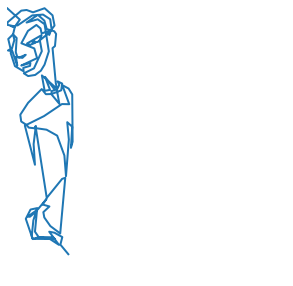

In [13]:
plot_stroke5(data[0])

### Compute Embeddings

In [14]:
emb, enc_output = t2.model.encode_from_seq(data)

In [15]:
emb.shape

torch.Size([100, 256])

In [16]:
embedding = emb

emb = emb[:2]

emb.shape

torch.Size([2, 256])

### Decoding V2

In [17]:
from torch import tensor
from torch.nn import functional as F

total_seq_len = hp.max_seq_length + 2

decoder_input = tensor([0., 0., 1., 0., 0.])
output = torch.ones((emb.shape[0], 1, 5)) * decoder_input

for i in range(total_seq_len):
    nattn = i + 1
    
    enc_input_dummy = make_dummy_input(
        total_seq_len=total_seq_len, nattn=nattn, batch_size=emb.shape[0])

    enc_padding_mask, dec_padding_mask, dec_target_padding_mask, look_ahead_mask = \
        create_masks(enc_input_dummy, output, device='cpu')

    final_output, attention_weights = t2.model.decode(
            embedding=emb,
            target=output,
            dec_padding_mask=dec_padding_mask,
            dec_target_padding_mask=dec_target_padding_mask,
            look_ahead_mask=look_ahead_mask)

    predictions = final_output[:, -1:, ...]  # (batch_size, 1, vocab_size)
    
    pred_location = predictions[..., :2]
    pred_metadata = F.one_hot(predictions[..., 2:].argmax(dim=-1), num_classes=3)
    
    predicted = torch.cat([pred_location, pred_metadata], dim=-1)
    
    output = torch.cat([output, predicted], dim=1)

/Users/al/miniconda3_m1/lib/python3.8/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [18]:
output

tensor([[[ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.9892e+00,  1.8630e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 4.3593e-02,  3.3237e-01,  1.0000e+00,  0.0000e+00,  0.0000e+00],
         ...,
         [ 3.8660e-03, -2.4356e-01,  1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 2.9766e-03, -2.3843e-01,  1.0000e+00,  0.0000e+00,  0.0000e+00],
         [-7.9760e-04, -2.3173e-01,  1.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 2.3089e+00,  1.7598e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 5.4868e-02,  3.6467e-01,  1.0000e+00,  0.0000e+00,  0.0000e+00],
         ...,
         [ 3.4480e-02, -7.3364e-02,  1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 3.7623e-02, -7.2400e-02,  1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 3.5026e-02, -6.6668e-02,  1.0000e+00,  0.0000e+00,  0.0000e+00]]],
       grad_fn=<CatBackward0>)

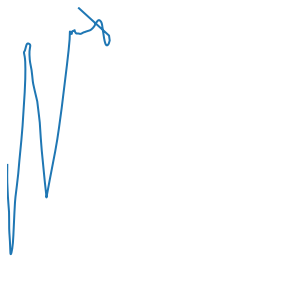

In [22]:
plot_stroke5(output[0].detach().numpy())

#### Decoding V1

In [ ]:

i = 1
total_seq_len = hp.max_seq_length + 2
# for i in range(seq_len):
nattn = i + 1

enc_input_dummy = make_dummy_input(
    total_seq_len=total_seq_len, nattn=nattn, batch_size=emb.shape[0])


In [ ]:
# enc_dummy_input

In [ ]:
enc_padding_mask, dec_padding_mask, dec_target_padding_mask, look_ahead_mask = \
    create_masks(enc_input_dummy, output, device='cpu')


In [ ]:
# dec_target_padding_mask

In [ ]:
final_output, attention_weights = t2.model.decode(
            embedding=emb,
            target=output,
            dec_padding_mask=dec_padding_mask,
            dec_target_padding_mask=dec_target_padding_mask,
            look_ahead_mask=look_ahead_mask)

In [ ]:
final_output.shape

torch.Size([100, 2, 5])

In [ ]:
final_output[1]

tensor([[ 0.6406,  1.2515,  3.3626, -1.4067, -1.6516],
        [ 0.2391,  0.7815,  3.6174, -1.3591, -1.7601]],
       grad_fn=<SelectBackward0>)

In [ ]:
final_output[2]

tensor([[ 0.6779,  1.3187,  3.3529, -1.3955, -1.6388],
        [ 0.2625,  0.8304,  3.6120, -1.3516, -1.7265]],
       grad_fn=<SelectBackward0>)

In [ ]:
predictions = final_output[:, -1:, ...]  # (batch_size, 1, vocab_size)

In [ ]:
torch.softmax(predictions[..., 2:], dim=-1).argmax(dim=-1, keepdim=True).shape

torch.Size([100, 1, 1])

In [ ]:
from torch.nn import functional as F

pred_location = predictions[..., :2]

pred_metadata = F.one_hot(predictions[..., 2:].argmax(dim=-1), num_classes=3)

predicted = torch.cat([pred_location, pred_metadata], dim=-1)

predicted.shape

torch.Size([100, 1, 5])

In [ ]:
predicted[0]

tensor([[0.2338, 0.7799, 1.0000, 0.0000, 0.0000]], grad_fn=<SelectBackward0>)

In [ ]:
output = torch.cat([output, predicted], dim=1)

In [ ]:
output.shape

torch.Size([100, 3, 5])

In [ ]:
output[0]

tensor([[0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.6339, 1.2458, 1.0000, 0.0000, 0.0000],
        [0.2338, 0.7799, 1.0000, 0.0000, 0.0000]], grad_fn=<SelectBackward0>)

In [ ]:
output[99]

tensor([[0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.6195, 1.2180, 1.0000, 0.0000, 0.0000],
        [0.2241, 0.7601, 1.0000, 0.0000, 0.0000]], grad_fn=<SelectBackward0>)

In [ ]:
data[0]

tensor([[ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.7478,  0.6953,  1.0000,  0.0000,  0.0000],
        [-0.2393,  0.3491,  1.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000]])

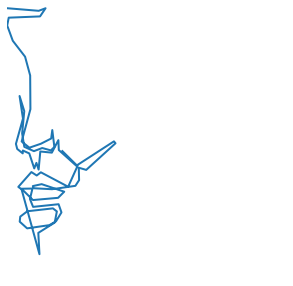

In [ ]:
idx = 99

pts = deltas_to_points(data[..., [0,1,3]][idx])
bb = BoundingBox.create(pts)

rescaled_pts = apply_transform(pts[:, :2], bb.normalization_xform())
rescaled_pts *= 200

rescaled_pts = np.concatenate([rescaled_pts, pts[:, 2].reshape(pts.shape[0], 1)], axis=1)

plot_strokes(points_to_strokes(rescaled_pts))

In [ ]:
# pts[:, 2].reshape(pts.shape[0], 1).shape

(252, 1)

In [ ]:
with_pencol = 

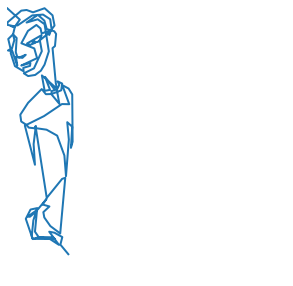

In [ ]:
# predicted = predictions
# predicted = tf.concat((predicted[..., :2],
#                        tf.nn.softmax(predicted[..., 2:], axis=-1)), axis=-1)
# finished_ones = np.sum(tf.argmax(predicted[...,  2:], axis=-1) == 2)
# output = tf.concat([output, predicted], axis=1)
# if finished_ones == emb.shape[0]:
#     break

In [ ]:
# from singleline_stroke3.display import *
# from singleline_stroke3.transforms import *